<a id='top'></a>
# Imaging Mode Data Calibration: Part 2 - Calibrated Slope Images
---
**Author**: Bryan Hilbert (hilbert@stsci.edu)| **Latest Update**:26 March 2021

## Table of Contents
* [Introduction](#intro)
* [Pipeline Resources and Documentation](#resources)
   * [Installation](#installation)
   * [Reference Files](#reference_files)
* [Imports](#Imports_ID)
* [Convenience Functions](#convenience_functions)
* [Download Data](#download_data)
* [Association Files](#associations)
* [Methods for calling steps/pipelines](#calling_methods)
* [calwebb_image2 - Calibrated slope images](#image2) 
   * [Run the entire pipeline](#image2_at_once)
   * [Run the individual pipeline steps](#image2_step_by_step)
       * [The `Group Scale` step](#groupscale)
       * [The `Data Quality Initialization` step](#dq_init)
       * [The `Saturation Flagging` step](#saturation)
       * [The `Inter-pixel Capacitance Correction` step](#ipc)
       * [The `Superbias Subtraction` step](#superbias)
       * [The `Reference Pixel Subtraction` step](#refpix)
       * [The `Linearity Correction` step](#linearity)
       * [The `Persistence Correction` step](#persistence)
       * [The `Dark Current Subtraction` step](#dc)
       * [The `Cosmic Ray Flagging` step](#jump)
       * [The `Ramp_Fitting` step](#ramp_fitting)
       * [The `Gain Scale` step](#gain_scale)

<div class="alert alert-block alert-warning">This is how you create a box around an important note.</div>

<a id='intro'></a>
## Introduction

This notebook covers part 2 of the imaging mode data calibration module. In this notebook we'll review Stage 2 of the JWST calibration pipeline for imaging data, also known as *calwebb\_image2*. 

The [Stage 2 pipeline](https://jwst-pipeline.readthedocs.io/en/stable/jwst/pipeline/calwebb_image2.html) applies instrumental corrections and calibrations to the slope images output from Stage 1. This includes background subtraction, the creation of a full World Coordinate System (WCS) for the data, application of the flat field, and flux calibration. The final output is an image in units of flux density. Whereas the input files had suffixes of *\_rate.fits*, the output files have suffixes of *\_cal.fits*.

In addition to the steps above, the Stage 2 pipeline will also run the [resample](https://jwst-pipeline.readthedocs.io/en/stable/jwst/resample/main.html) step on the calibrated images, in order to remove the effects of instrument distortion. This step outputs files with the suffix *\_i2d.fits* that contain "rectified" images. However, these files are meant only for user examination of the data. It is the *\_cal.fits* files that are passed on to Stage 3 of the pipeline.

To illustrate how the steps of the pipeline change the input data, we will download several sample files and run them through the pipeline, examining the results at several places along the way.

All JWST imaging mode data, regardless of instrument, are processed through the *calwebb\_image2* pipeline. The steps and the order in which they are performed is the same for all data. For the purposes of this notebook, we will continue with the processing of the NIRCam data used in the Stage 1 notebook. We will also provide example MIRI files that can be used in a separate exercise.

<a id='resources'></a>
## Pipeline Resources and Documentation

Visit the [webpage for JWebbinars](https://www.stsci.edu/jwst/science-execution/jwebbinars) to find resources for:

* JWST Documentation (JDox) for the Stage 1 pipeline
* Additional documentation about the pipeline and pipeline stages in readthedocs



There are several different places to find information on installing and running the pipeline. This notebook will give a shortened description of the steps pulled from the detailed pipeline information pages, but to find more in-depth instructions use the links below.


* [`jwst` package GitHub repository, with installation instructions](https://github.com/spacetelescope/jwst/blob/master/README.md)
* [`jwst` package documentation](https://jwst-pipeline.readthedocs.io/en/latest/jwst/introduction.html)
* [Help Desk](https://stsci.service-now.com/jwst?id=sc_cat_item&sys_id=27a8af2fdbf2220033b55dd5ce9619cd&sysparm_category=e15706fc0a0a0aa7007fc21e1ab70c2f): If you have any questions or problems regarding the pipeline, submit a ticket to the Help Desk 

<a id='installation'></a>
### Installation

The `jwst` package on GitHub contains all JWST calibration pipeline software.

For detailed installation instructions, see the [installation instructions](https://github.com/spacetelescope/jwst/blob/master/README.md) on GitHub.

The easiest way to install the pipeline is via `pip`. Below we show how to create a new conda environment, activate that environment, and then install the latest released version of the pipeline. You can name your environment anything you like. In the lines below, replace <env_name> with your chosen environment name.

>`conda create -n <env_name> python`<br>
>`conda activate <env_name>`<br>
>`pip install jwst`

If you wish to install the development version of the pipeline, which is more recent than (but not as well tested compared to) the latest released version:

>`conda create -n <env_name> python`<br>
>`conda activate <env_name>`<br>
>`pip install git+https://github.com/spacetelescope/jwst`

<a id='reference_files'></a>
### Reference Files

Users at STScI should automatically have access to the Calibration Reference Data System (CRDS) cache for running the pipeline. For outside users, it is recommended to have the CRDS server download the reference files to your local system and use that local cache when running the pipeline. To do that, there are two environment variables that should be set prior to calling the pipeline. These are the CRDS_PATH and CRDS_SERVER_URL variables. In the example below, reference files will be downloaded to the "crds_cache" directory under the home directory.

>`$ export CRDS_PATH=$HOME/crds_cache`<br>
>`$ export CRDS_SERVER_URL=https://jwst-crds.stsci.edu`

The first time you invoke the pipeline, the CRDS server should download all of the context and reference files that are needed for that pipeline run, and dump them into the CRDS_PATH directory. Subsequent executions of the pipeline will first look to see if it has what it needs in CRDS_PATH and anything it doesn't have will be downloaded from the STScI cache. 

[Top of Notebook](#top)

<a id=#Imports_ID></a>
## Imports

Import packages necessary for this notebook

In [113]:
# Module with functions to get information about objects:
from glob import glob
import os
import inspect

# Numpy library:
import numpy as np

# To read association file
import json

# Astropy tools:
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch, LinearStretch

Set up matplotlib for plotting

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Use this version for non-interactive plots (easier scrolling of the notebook)
# %matplotlib inline

# Use this version if you want interactive plots
%matplotlib notebook

# These gymnastics are needed to make the sizes of the figures
# be the same in both the inline and notebook versions
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

Import JWST pipeline-related modules

In [4]:
# The entire calwebb_detector1 pipeline
from jwst.pipeline import calwebb_image2

# Individual steps that make up calwebb_detector1
from jwst.background import BackgroundStep
from jwst.assign_wcs import AssignWcsStep                                                                                                                                                                                        
from jwst.flatfield import FlatFieldStep                                                                                                                                                                                         
from jwst.photom import PhotomStep                                                                                                                                                                                               
from jwst.resample import ResampleStep   
from jwst import datamodels

Check which version of the pipeline we are running:

In [5]:
import jwst
print(jwst.__version__)

1.1.0


<a id='convenience_functions'></a>
## Define convenience functions and parameters

Here we define some functions that we will use repeatedly throughout the notebook.

In [6]:
base_dir = '/ifs/jwst/wit/nircam/hilbert/simulated_data_sets/JWebbinars/imaging_mode/'

In [ ]:
base_dir = './'

In [ ]:
# Define the name of the Stage 1 output directory. This is where rate files
# will be sitting. Use the same path as was used in the Stage 1 notebook
stage1_dir = os.path.abspath(os.path.join(base_dir, 'Stage1'))

In [ ]:
# Make sure the Stage 1 directory exists before downloading any data
if not os.path.exists(stage1_dir):
    os.makedirs(stage1_dir)

In [7]:
# Files created or downloaded in this notebook will be saved
# in a subdirectory of the base directory called `Stage2`
output_dir = os.path.abspath(os.path.join(base_dir, 'Stage2'))

In [ ]:
# Make sure the output directory exists before downloading any data
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [114]:
def show_image(data_2d, vmin, vmax, xpixel=None, ypixel=None, title=None,
               scale='log', units='MJy/str'):
    """Function to generate a 2D, log-scaled image of the data, 
    with an option to highlight a specific pixel.
    """
    if scale == 'log':
        norm = ImageNormalize(data_2d, interval=ManualInterval(vmin=vmin, vmax=vmax),
                              stretch=LogStretch())
    elif scale == 'linear':
        norm = ImageNormalize(data_2d, interval=ManualInterval(vmin=vmin, vmax=vmax),
                              stretch=LinearStretch())
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(data_2d, origin='lower', norm=norm)
    
    if xpixel and ypixel:
        plt.plot(xpixel, ypixel, marker='o', color='red', label='Selected Pixel')

    fig.colorbar(im, label=units)
    plt.xlabel('Pixel column')
    plt.ylabel('Pixel row')
    if title:
        plt.title(title)

[Top of Notebook](#top)

<a id='download_data'></a>
## Download Data

For this module, we will use rate files from a NIRCam simulated imaging exposure that is stored in Box. Let's grab them:

In [150]:
def download(url, filename):
    """Download the given URL into the given filename
    """
    demo_file = download_file(url)

    # Save the file so that we can use it later
    with fits.open(demo_file, ignore_missing_end=True) as f:
        f.writeto(filename, overwrite=True)

In [ ]:
rate_file_urls = ['https://stsci.box.com/s/g6316wjr4mv936rlouzdjeq065s7ou6g',
                  'https://stsci.box.com/s/z2xunff1d2g3m3fjxc1fixoz8rjfpl7h',
                  'https://stsci.box.com/s/4xuvt56kr7gix7dx3tntek6wc9kockef',
                  'https://stsci.box.com/s/lzhcnzds2l7mpf92oet1u69uof788u3l'
                 ]

rate_file_names = ['jw98765001001_01101_00001_nrcb5_rate.fits',
                   'jw98765001001_01101_00001_nrcb5_rate.fits',
                   'jw98765001001_01101_00001_nrcb5_rate.fits',
                   'level2_lw_asn.json'
                  ]

Download the rate files into the Stage1 directory.

In [ ]:
for rate_url, rate_file in zip(rate_file_urls, rate_file_names):
    download(rate_url, os.path.join(stage1_dir, rate_file))

You can also download the example MIRI files if you wish to try the exercise of running it through the pipeline.

In [ ]:
miri_file_urls = []

miri_file_names = []

In [ ]:
for rate_url, rate_file in zip(miri_file_urls, miri_file_names):
    download(rate_url, os.path.join(stage1_dir, rate_file))

You can also download the example NIRCam shortwave ratefiles that correspond to the longwave files used in this notebook if you wish to try the exercise of running them through the pipeline.

In [ ]:
sw_rate_file_urls = []

sw_rate_file_names = []

In [ ]:
for rate_url, rate_file in zip(sw_rate_file_urls, sw_rate_file_names):
    download(rate_url, os.path.join(stage1_dir, rate_file))

<a id='associations'></a>
## Association Files

The Stage 2 pipeline can be called on a single fits file, or a collection of fits files. When calling on multiple files, the input is a json-formatted file called an ["association" file](https://jwst-pipeline.readthedocs.io/en/stable/jwst/associations/index.html). When retrieving your observations from MAST, you will be able to download the association files for your data along with the fits files containing the observations.

The association file presents your data files in organized groups. Let's open the level 2 association file for the data to be processed in this notebook and look at its contents.

In [146]:
#asn_file = os.path.join(base_dir, 'sim_data/level2_lw_asn.json')
asn_file = os.path.join(stage1_dir, 'level2_lw_asn.json')

In [147]:
with open(asn_file) as f_obj:
  asn_data = json.load(f_obj)

In [148]:
asn_data

{'asn_type': 'None',
 'asn_rule': 'DMSLevel2bBase',
 'version_id': None,
 'code_version': '0.17.1',
 'degraded_status': 'No known degraded exposures in association.',
 'program': 'noprogram',
 'constraints': 'No constraints',
 'asn_id': 'a3001',
 'asn_pool': 'none',
 'products': [{'name': 'jw98765001001_01101_00001_nrcb5',
   'members': [{'expname': '/ifs/jwst/wit/nircam/hilbert/simulated_data_sets/JWebbinars/imaging_mode/output/jw98765001001_01101_00001_nrcb5_rate.fits',
     'exptype': 'science'}]},
  {'name': 'jw98765001001_01101_00002_nrcb5',
   'members': [{'expname': '/ifs/jwst/wit/nircam/hilbert/simulated_data_sets/JWebbinars/imaging_mode/output/jw98765001001_01101_00002_nrcb5_rate.fits',
     'exptype': 'science'}]},
  {'name': 'jw98765001001_01101_00003_nrcb5',
   'members': [{'expname': '/ifs/jwst/wit/nircam/hilbert/simulated_data_sets/JWebbinars/imaging_mode/output/jw98765001001_01101_00003_nrcb5_rate.fits',
     'exptype': 'science'}]},
  {'name': 'jw98765001001_01101_00004

Here we see that the association file begins with a few lines of data that give high-level information about the association. The most important entry here is the `asn_rule` field. Association files have different formats for the different stages of the pipeline. You should be sure that the `asn_rule` matches the pipeline that you will be running. In this case we'll be running the Stage 2 pipeline, and we see that the `asn_rule` mentions "Level2b", which is what we want.

Beneath these lines, we see the `products` field. This field contains a list of dictionaries that specify the files that belong to this association, and the types of those files. When the Stage 2 pipeline is run on this association file, all files listed here will be run through the calibration steps.

<a id='calling_methods'></a>
## Methods for calling steps/pipelines

There are three common methods by which the pipeline or pipeline steps can be called. From within python, the `run()` and `call()` methods can be used. Or, the `strun` command can be used from the command line. When using the `call()` method or `strun`, optional input parameters can be specified via [configuration files](#parameter_reffiles). When using the `run()` method, these parameters are instead specified within python. See below for details on all three methods.

Below, where we [call the entire pipeline](#detector1_at_once), as well as the section where we [call the Reference Pixel Subtraction](#refpix) step, we show examples of all three methods. For the remainder of the pipeline steps, we will focus on using the `run()` method.

<a id='run_method'></a>
### Run() method

When using the `run()` method to execute a pipeline (or step), the pipeline class is first instantiated without the data to be processed. Optional input parameters are specified using attributes of the class instance. Finally, the call to the `run()` method is made and the data are supplied.  See here for [example usage of run() method](https://jwst-pipeline.readthedocs.io/en/stable/jwst/stpipe/call_via_run.html).

<a id='parameter_reffiles'></a>
### Parameter Reference Files

When calling a pipeline or pipeline step using the call() method or the command line, 

show some examples here.

[ASDF configuration file details](https://jwst-pipeline.readthedocs.io/en/stable/jwst/stpipe/config_asdf.html#config-asdf-files)

<a id='call_method'></a>
### call() method

When using the `call()` method to execute a pipeline (or step), the input data and optional paramter reference files are supplied to the pipeline class when it is instantiated. In this case, any desired input parameters must be set in the parameter reference files. They cannot be set after instantiation, as with the `run()` method. See here for [example usage of call() method](https://jwst-pipeline.readthedocs.io/en/stable/jwst/stpipe/call_via_call.html).

<a id='command_line'></a>
### Command line

Calling a pipeline, or step, from the command line is similar to using the `call()` method. Parameter reference files and the data file to be processed are provided to the `strun` command. All desired input paramter values must be specified within the parameter reference files. See here for [example usage of command line calls](https://jwst-pipeline.readthedocs.io/en/stable/jwst/introduction.html?highlight=%22command%20line%22#running-from-the-command-line).

[Top of Notebook](#top)

---
<a id='image2'></a>
## The calwebb_image2 pipeline: Calibrated slope images

In the sections below, we will run the Stage 2 pipeline using an association file containing several NIRCam exposures. We will first call the entire *calwebb_image2* pipeline itself. The pipeline is a wrapper which will string together all of the appropriate steps in the proper order. The final output from this call is an calibrated slope image which is ready to go into the Stage 3 pipeline.

After that, we will go back to the original uncalibrated slope images and manually run them through each of the steps that comprise the Stage 2 pipeline. For each step we will describe in more detail what is going on and examine how the exposure files have changed.

See [Figure 1](https://jwst-docs.stsci.edu/jwst-data-reduction-pipeline/algorithm-documentation/stages-of-processing/calwebb_image2) on the calwebb_image2 algorithm page for a map of the steps are performed on the input data.

<a id='image2_at_once'></a>
### Run the entire `calwebb_image2` pipeline

In this section we show how to run the entire calwebb_image2 pipeline with a single call. 

We show all three methods for calling the pipeline.


We set parameter values for some of the individual steps, save some outputs, etc, and then call the pipeline.

[Pipeline output suffixes](https://jwst-pipeline.readthedocs.io/en/stable/jwst/introduction.html#pipeline-step-suffix-definitions)




##### Using the run() method

In [37]:
# Create an instance of the pipeline class
image2 = calwebb_image2.Image2Pipeline()

# Set some parameters that pertain to the
# entire pipeline
image2.output_dir = output_dir
image2.save_results = True

# Set some parameters that pertain to some of
# the individual steps
image2.bkg_subtract.sigma = 3.0  # this is the default. Set here as an example
image2.resample.pixfrac = 1.0    # this is the default. Set here as an example

# Call the run() method
image2.run(asn_file)

2021-03-31 15:09:14,122 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.
2021-03-31 15:09:14,125 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2021-03-31 15:09:14,127 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2021-03-31 15:09:14,129 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2021-03-31 15:09:14,131 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.
2021-03-31 15:09:14,133 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.
2021-03-31 15:09:14,260 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('/ifs/jwst/wit/nircam/hilbert/simulated_data_sets/JWebbinars/imaging_mode/sim_data/level2_lw_asn.json',).
2021-03-31 15:09:14,267 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/ifs/jwst/wit/nircam/hilbert/simulated_data_sets/J

2021-03-31 15:09:26,414 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  12.015613916 11.983982600 12.015181985 12.020176925 11.978915493 12.020098805 11.978486069 11.984168244
2021-03-31 15:09:26,415 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2021-03-31 15:09:26,512 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done
2021-03-31 15:09:26,588 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(2048, 2048) from jw98765001001_01101_00001_nrcb5_rate.fits>,).
2021-03-31 15:09:26,589 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/ifs/jwst/wit/nircam/hilbert/simulated_data_sets/JWebbinars/imaging_mode/sim_d

2021-03-31 15:10:13,386 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done
2021-03-31 15:10:13,478 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(2048, 2048) from jw98765001001_01101_00002_nrcb5_rate.fits>,).
2021-03-31 15:10:13,481 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'photom', 'search_output_file': True, 'input_dir': '/ifs/jwst/wit/nircam/hilbert/simulated_data_sets/JWebbinars/imaging_mode/sim_data', 'inverse': False, 'source_type': None}
2021-03-31 15:10:13,572 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_nircam_photom_0067.fits
2021-03-31 15:10:13,573 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/j

2021-03-31 15:11:06,643 - stpipe.Image2Pipeline.photom - INFO - Using instrument: NIRCAM
2021-03-31 15:11:06,643 - stpipe.Image2Pipeline.photom - INFO -  detector: NRCBLONG
2021-03-31 15:11:06,644 - stpipe.Image2Pipeline.photom - INFO -  exp_type: NRC_IMAGE
2021-03-31 15:11:06,645 - stpipe.Image2Pipeline.photom - INFO -  filter: F444W
2021-03-31 15:11:06,645 - stpipe.Image2Pipeline.photom - INFO -  pupil: CLEAR
2021-03-31 15:11:06,741 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.
2021-03-31 15:11:06,743 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 0.467368
2021-03-31 15:11:06,765 - stpipe.Image2Pipeline.photom - INFO - Step photom done
2021-03-31 15:11:06,870 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(2048, 2048) from jw98765001001_01101_00003_nrcb5_rate.fits>,).
2021-03-31 15:11:06,872 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file

2021-03-31 15:11:50,022 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_nircam_drizpars_0001.fits
2021-03-31 15:11:52,501 - stpipe.Image2Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2067, 2074)
2021-03-31 15:11:54,153 - stpipe.Image2Pipeline.resample - WARNING - /Users/hilbert/miniconda3/envs/jwst-py3.8/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)

2021-03-31 15:11:54,1

[<ImageModel(2048, 2048) from jw98765001001_01101_00001_nrcb5_cal.fits>,
 <ImageModel(2048, 2048) from jw98765001001_01101_00002_nrcb5_cal.fits>,
 <ImageModel(2048, 2048) from jw98765001001_01101_00003_nrcb5_cal.fits>,
 <ImageModel(2048, 2048) from jw98765001001_01101_00004_nrcb5_cal.fits>]

##### Using the call() method

In [ ]:
make sure that this works, but dont call it during the webbinar. no sense in having people wait through
multiple pipeline calls on the same file

# At instantiation, provide the name of the 
# observation file, the pipeline-specific input
# paramters, and the name of the parameter reference
# files that specify step-specific parameters
call_output = calwebb_image2. Image2Pipeline.call(asn_file, output_dir=output_dir,
                                                  save_results=True, config_file='')

# Here is another way to use the call() method. In this case,
# you build a nested dictionary that specifies parameter values
# for various steps, and provide it in the call to call().
parameter_dict = {"bkg_subtract": {"sigma": 3.0},
                  "resample": {"pixfrac": 1.0}
                 }
Image2Pipeline.call(asn_file, output_dir=output_dir, save_results=True,
                    config_file='', steps=parameter_dict)

##### From the command line

In [ ]:
make sure that this works, but dont call it during the webbinar. no sense in having people wait through
multiple pipeline calls on the same file

# Similar to the use of the call() method above, we
# provide the name of the observation file, pipeline-
# specific parameters, and the names of step-specific
# parameter reference files.

need param reffile option here...

# Remember that this must be run on the command line,
# rather than in this notebook
# strun jwst.pipeline.Detector1Pipeline <uncal_filename> --steps.refpix.use_side_ref_pix=True --steps.linearity.save_results=True --steps.jump.rejection_threshold=6



### Examine the outputs

Get the filenames from the association file

In [29]:
input_files = [item['members'][0]['expname'] for item in asn_data['products']]       

In [30]:
input_files

['/ifs/jwst/wit/nircam/hilbert/simulated_data_sets/JWebbinars/imaging_mode/output/jw98765001001_01101_00001_nrcb5_rate.fits',
 '/ifs/jwst/wit/nircam/hilbert/simulated_data_sets/JWebbinars/imaging_mode/output/jw98765001001_01101_00002_nrcb5_rate.fits',
 '/ifs/jwst/wit/nircam/hilbert/simulated_data_sets/JWebbinars/imaging_mode/output/jw98765001001_01101_00003_nrcb5_rate.fits',
 '/ifs/jwst/wit/nircam/hilbert/simulated_data_sets/JWebbinars/imaging_mode/output/jw98765001001_01101_00004_nrcb5_rate.fits']

In [31]:
output_files = sorted(glob(os.path.join(output_dir, '*_cal.fits')))
#output_files = [f.replace('rate.fits', 'cal.fits') for f in input_files]

In [32]:
output_files

['/ifs/jwst/wit/nircam/hilbert/simulated_data_sets/JWebbinars/imaging_mode/output/jw98765001001_01101_00001_nrcb5_cal.fits',
 '/ifs/jwst/wit/nircam/hilbert/simulated_data_sets/JWebbinars/imaging_mode/output/jw98765001001_01101_00002_nrcb5_cal.fits',
 '/ifs/jwst/wit/nircam/hilbert/simulated_data_sets/JWebbinars/imaging_mode/output/jw98765001001_01101_00003_nrcb5_cal.fits',
 '/ifs/jwst/wit/nircam/hilbert/simulated_data_sets/JWebbinars/imaging_mode/output/jw98765001001_01101_00004_nrcb5_cal.fits']

In [39]:
cal_data = fits.open(output_files[0])

2021-03-31 15:25:25,392 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst-py3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



In [40]:
cal_data.info()

Filename: /ifs/jwst/wit/nircam/hilbert/simulated_data_sets/JWebbinars/imaging_mode/output/jw98765001001_01101_00001_nrcb5_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     263   ()      
  1  SCI           1 ImageHDU        85   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  AREA          1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (2048, 2048)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [17329B]   


Let's look at the header of the SCI extension, to see the information that has been added by the assign WCS and flux calibration steps.

In [44]:
cal_data['SCI'].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 2048                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'SCI     '           / extension name                                 
BUNIT   = 'MJy/sr  '           / physical units of the array values             
                                                                                
        Photometry information                                                  
                                                                                
PHOTMJSR=   0.46736836433410

<a id='pipeline_output_view'></a>
Display the calibrated slope image

<IPython.core.display.Javascript object>


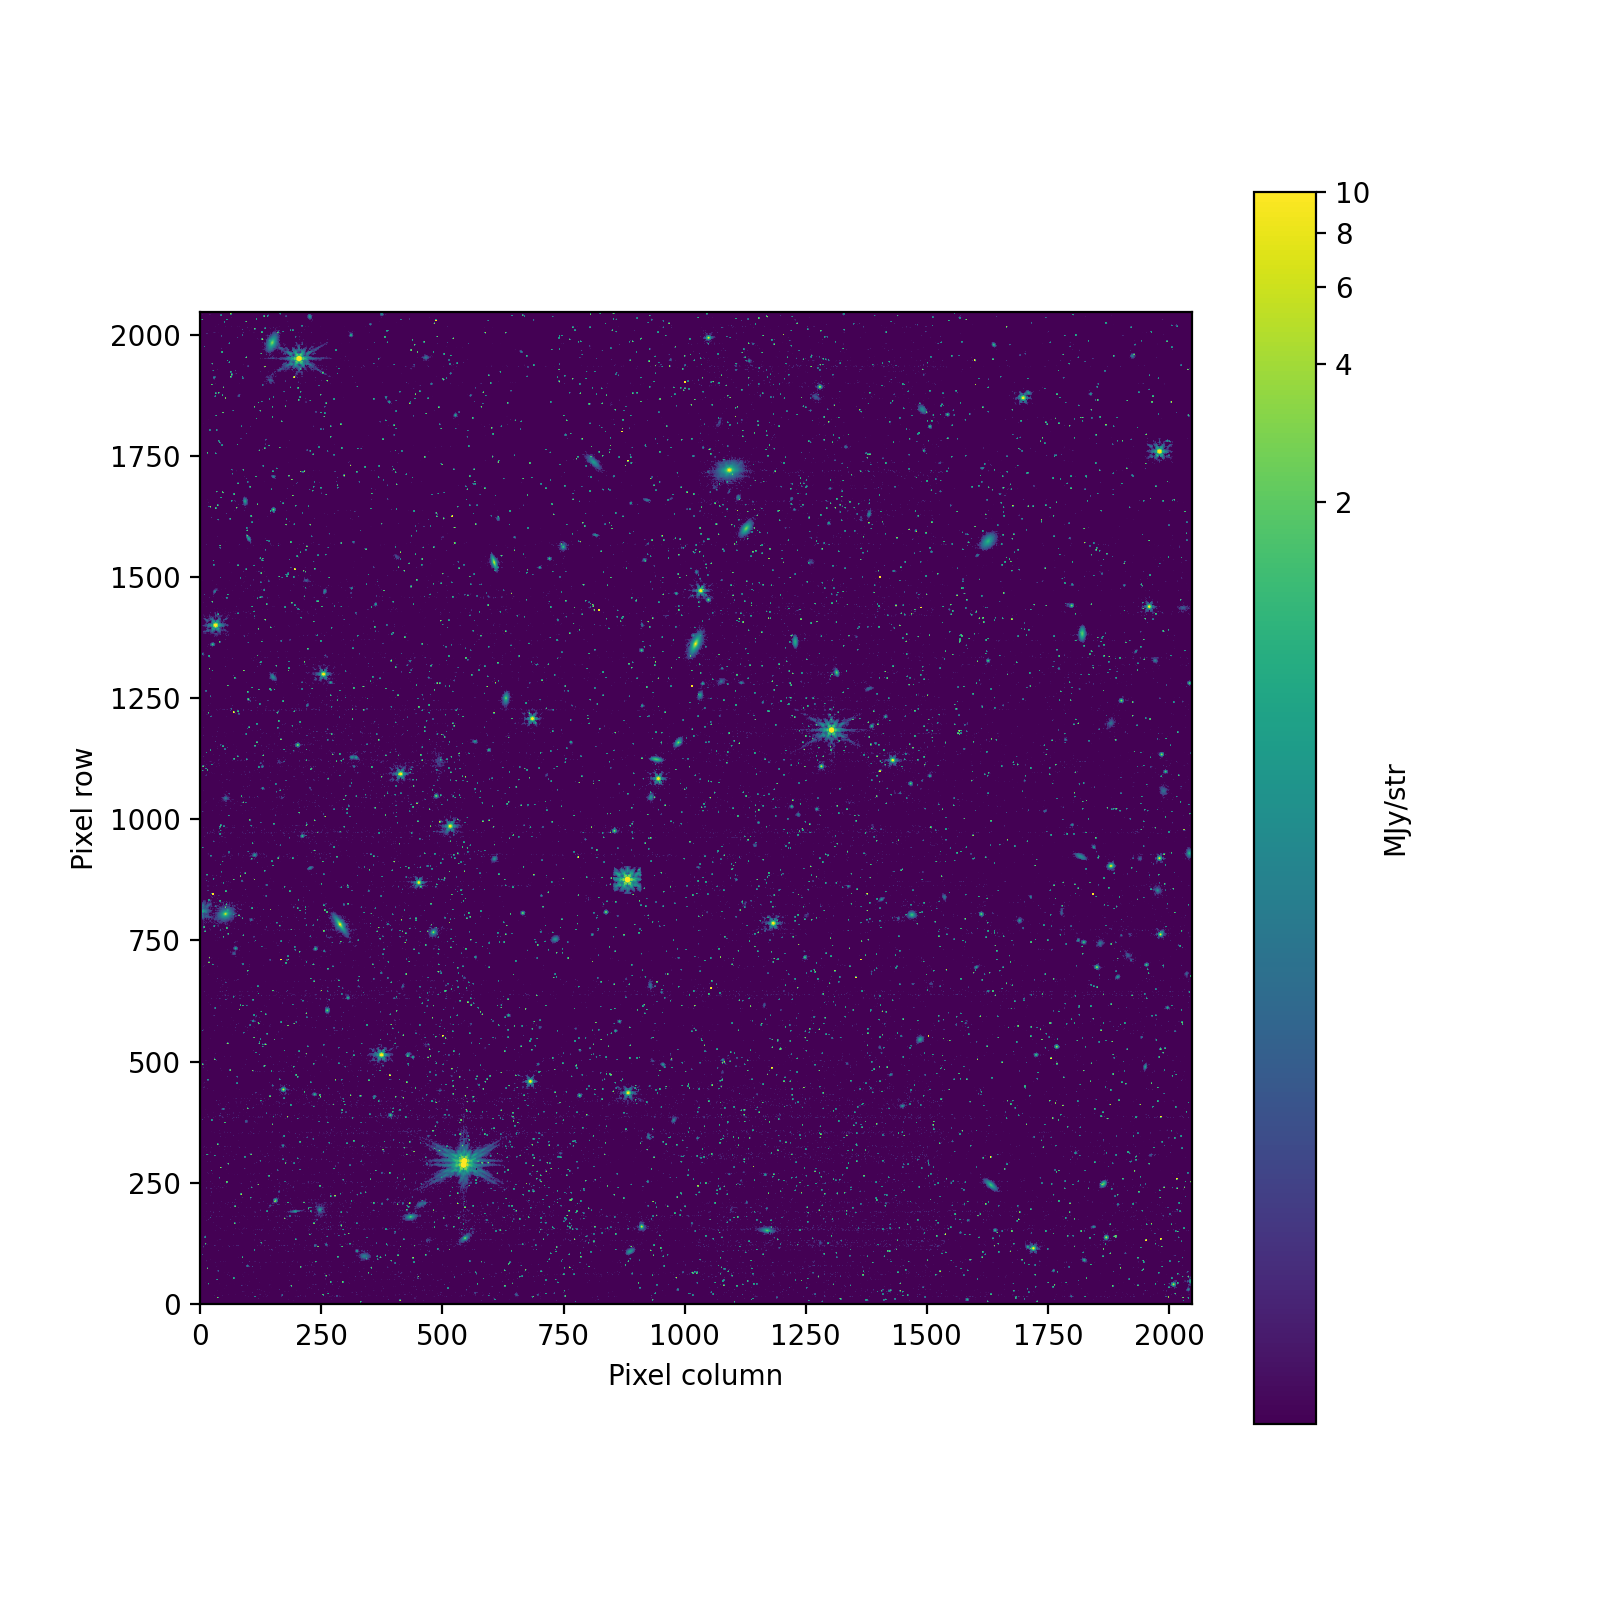

In [73]:
show_image(cal_data[1].data, 0.3, 10)

[Top of Notebook](#top)

<a id='detector1_step_by_step'></a>
## Run the individual pipeline steps

In the sections below we run the steps contained within calwebb_image2 one at a time, in order to more clearly see what each step is doing.

<a id='assign_wcs'></a>
### The `WCS creation` step

#### Summary

This step 

#### Documentation

[Full description](https://jwst-pipeline.readthedocs.io/en/stable/jwst/assign_wcs/main.html) of the step.

#### Arguments

There are no optional arguments for this step.

#### Reference files used

The [reference files used](https://jwst-pipeline.readthedocs.io/en/stable/jwst/assign_wcs/reference_files.html) in this step depend on the instrument used. The primary reference file used is the `DISTORTION` reference file, which contains coefficients that can be used to translate between various coordinate systems.

#### Run the step

The assign_wcs step expects an instance of an ImageModel as input, rather than an association file or fits file. So in this case we'll loop over the input files, read them into ImageCube instances, and call the step. Results will be saved to fits files.

In [58]:
for filename in input_files:
    image = datamodels.ImageModel(filename)
    
    # Using the run() method
    assign_wcs_step = AssignWcsStep()
    assign_wcs_step.output_dir = output_dir
    assign_wcs_step.save_results = True
    assign_wcs_step.run(filename)

2021-03-31 15:38:29,203 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2021-03-31 15:38:29,287 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('/ifs/jwst/wit/nircam/hilbert/simulated_data_sets/JWebbinars/imaging_mode/output/jw98765001001_01101_00001_nrcb5_rate.fits',).
2021-03-31 15:38:29,290 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/ifs/jwst/wit/nircam/hilbert/simulated_data_sets/JWebbinars/imaging_mode/output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2021-03-31 15:38:30,351 - stpipe.AssignWcsStep - WARNING - /Users/hilbert/miniconda3/envs

2021-03-31 15:41:12,037 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  12.017317813 11.983926352 12.016885882 12.020120677 11.980619399 12.020042558 11.980189974 11.984111996
2021-03-31 15:41:12,037 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  12.017317813 11.983926352 12.016885882 12.020120677 11.980619399 12.020042558 11.980189974 11.984111996
2021-03-31 15:41:12,038 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs
2021-03-31 15:42:07,916 - stpipe.AssignWcsStep - INFO - Saved model in /ifs/jwst/wit/nircam/hilbert/simulated_data_sets/JWebbinars/imaging_mode/output/jw98765001001_01101_00004_nrcb5_assignwcsstep.fits
2021-03-31 15:42:07,917 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


In [62]:
# When the output is saved, the assign_wcs step will
# attach a suffix of 'assignwcsstep' to the input filename.
assign_wcs_output_files = sorted(glob(os.path.join(output_dir, '*_assignwcsstep.fits')))

Let's look into the WCS information that this step added to the files

In [63]:
model = datamodels.ImageModel(assign_wcs_output_files[0])

The full GWCS model is contained in the ASDF extension of the file, and can be seen through the `meta` property. 

In [65]:
# Look at the WCS info in the calibrated image model 
model.meta.wcs

<WCS(output_frame=world, input_frame=detector, forward_transform=Model: CompoundModel
Inputs: ('x0', 'x1')
Outputs: ('lon', 'lat')
Model set size: 1
Expression: [0] & [1] | [2] & [3] | [4] | [5] & [6] | [7] | [8] & [9] | [10] & [11] | [12] | [13] & [14] | [15] | [16] | [17]
Components: 
    [0]: <Shift(offset=1.)>

    [1]: <Shift(offset=1.)>

    [2]: <Shift(offset=-1024.5)>

    [3]: <Shift(offset=-1024.5)>

    [4]: <Mapping((0, 1, 0, 1))>

    [5]: <Polynomial2D(5, c0_0=-0., c1_0=0.06287861, c2_0=-0.00000011, c3_0=0., c4_0=-0., c5_0=0., c0_1=0., c0_2=0.0000001, c0_3=0., c0_4=0., c0_5=-0., c1_1=-0.00000072, c1_2=0., c1_3=-0., c1_4=0., c2_1=0., c2_2=0., c2_3=-0., c3_1=-0., c3_2=0., c4_1=-0.)>

    [6]: <Polynomial2D(5, c0_0=0., c1_0=0.00008446, c2_0=0.00000031, c3_0=0., c4_0=0., c5_0=-0., c0_1=0.06317477, c0_2=-0.00000042, c0_3=0., c0_4=-0., c0_5=0., c1_1=-0.00000023, c1_2=0., c1_3=-0., c1_4=-0., c2_1=0., c2_2=0., c2_3=0., c3_1=-0., c3_2=-0., c4_1=0.)>

    [7]: <Mapping((0, 1, 0, 1)

There are several world coordinate systems available in the file. 

In [67]:
# What coordinate frames are available?
model.meta.wcs.available_frames

['detector', 'v2v3', 'v2v3vacorr', 'world']

In [68]:
model.meta.wcs.input_frame

<Frame2D(name="detector", unit=(Unit("pix"), Unit("pix")), axes_names=('x', 'y'), axes_order=(0, 1))>

In [69]:
model.meta.wcs.output_frame

<CelestialFrame(name="world", unit=(Unit("deg"), Unit("deg")), axes_names=('lon', 'lat'), axes_order=(0, 1), reference_frame=<ICRS Frame>)>

Let's create a transformation function to go from detector pixels to location on the sky.

In [70]:
# Get the transform to go from detector to world coordinates (use: detector_to_world)
detector_to_world = model.meta.wcs.get_transform('detector', 'world')

And a function for the inverse transformation

In [85]:
world_to_detector = model.meta.wcs.get_transform('world', 'detector')

Let's show again the pipeline output image from above, and zoom in on an interesting area

<IPython.core.display.Javascript object>


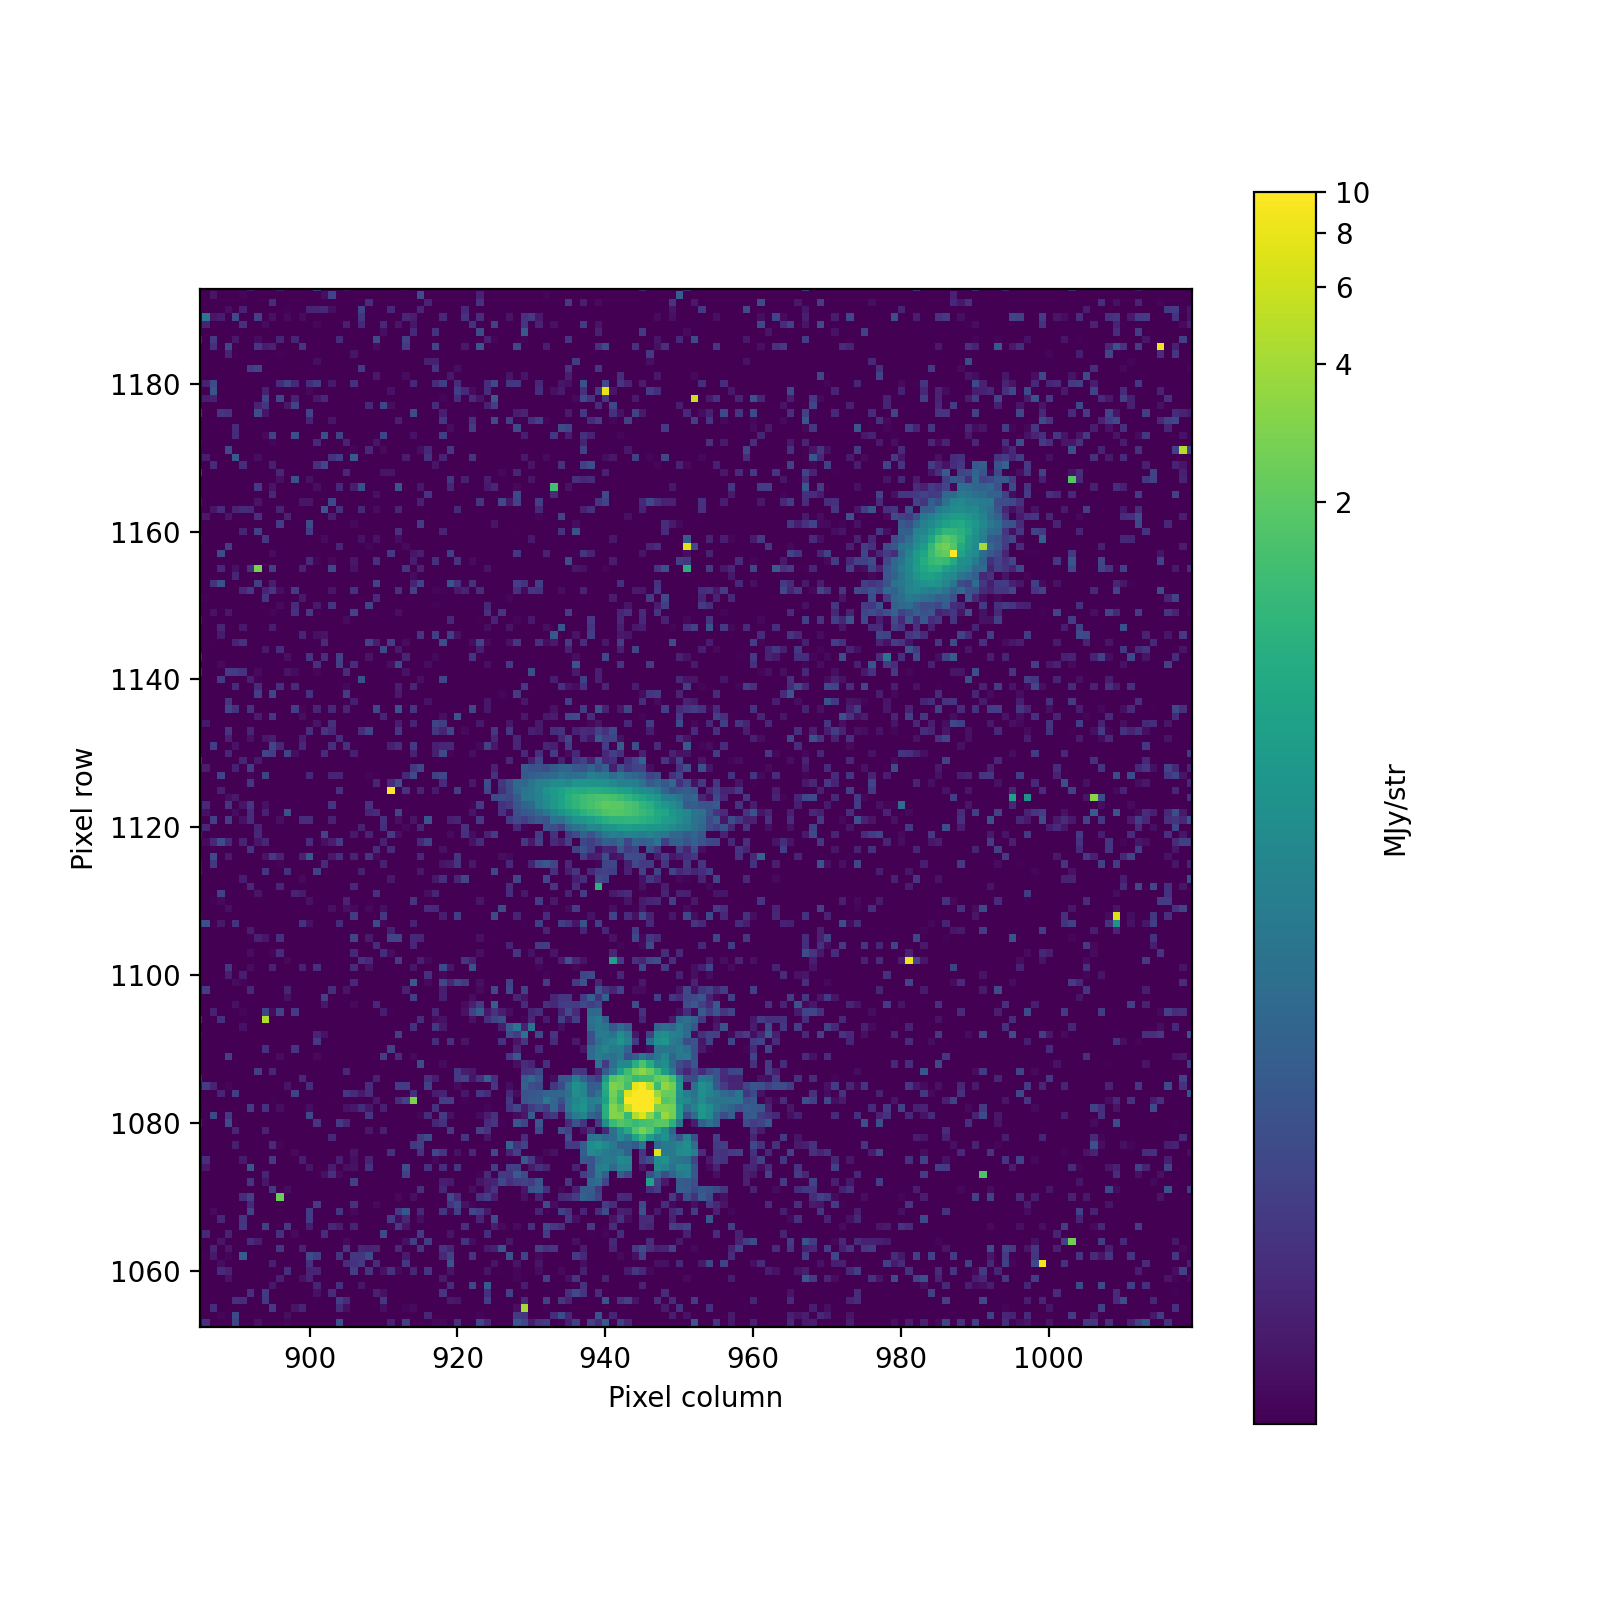

In [75]:
show_image(cal_data[1].data , 0.3, 10)

Using the transformation functions we defined above, we can now easily determine the RA and Dec of these sources

In [77]:
sources_x = [945., 940., 985.]
sources_y = [1083.5, 1123., 1158.2]

In [79]:
sources_ra, sources_dec = detector_to_world(sources_x, sources_y)

In [80]:
sources_ra

array([11.99845457, 11.99854302, 11.99773972])

In [81]:
sources_dec

array([12.00318058, 12.00387321, 12.00449042])

And now the opposite case: My target is at a given RA and Dec, so where is it in this image?

In [91]:
targ_ra = 12.012546822378457
targ_dec = 12.018984533659786

In [92]:
targ_x, targ_y = world_to_detector(targ_ra, targ_dec)

In [94]:
print('Target located at (x, y) = ({}, {})'.format(targ_x, targ_y))

Target located at (x, y) = (148.54776647961341, 1982.0105353987901)


<a id='background_subtraction'></a>
### The `Background subtraction` step

#### Summary

This step subtracts a background image from the exposure. A single background image or a list of background images can be provided. If a list is provided, the pipeline creates a sigma-clipped mean background image, which is then subtracted.

Normally for imaging observations, there will not be any dedicated background observations, and this step will be skipped. In cases where background observations are present, they will be listed in the association file. In this case, when the pipeline is run, the background subtraction step will be executed.

#### Documentation

[Full description](https://jwst-pipeline.readthedocs.io/en/stable/jwst/background/description.html) of the step.

#### Arguments

There are [several optional arguments](https://jwst-pipeline.readthedocs.io/en/stable/jwst/background/arguments.html) for this step.

#### Reference files used

This step does not use any reference files when working on imaging mode data.


## Skip this step here?

#### Should we add a background image to our association file in order to show this step working? I'm not sure when this would ever be the case for nircam.

#### Run the step

In [ ]:
background_files = []

In [95]:
for filename in assign_wcs_output_files:
    # Using the run() method
    background_step = BackgroundStep()
    background_step.output_dir = output_dir
    background_step.save_results = True
    background_step.run(filename, background_files)

2021-03-31 16:20:45,280 - stpipe.BackgroundStep - INFO - BackgroundStep instance created.
2021-03-31 16:20:45,410 - stpipe.BackgroundStep - INFO - Step BackgroundStep running with args ('/ifs/jwst/wit/nircam/hilbert/simulated_data_sets/JWebbinars/imaging_mode/output/jw98765001001_01101_00001_nrcb5_assignwcsstep.fits',).
2021-03-31 16:20:45,412 - stpipe.BackgroundStep - INFO - Step BackgroundStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/ifs/jwst/wit/nircam/hilbert/simulated_data_sets/JWebbinars/imaging_mode/output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sigma': 3.0, 'maxiters': None}


TypeError: process() missing 1 required positional argument: 'bkg_list'

In [ ]:
# When the output is saved, the background step will
# attach a suffix of 'backgroundstep' to the input filename.
background_output_files = sorted(glob(os.path.join(output_dir, '*_backgroundstep.fits')))

The step finished without crashing, but as it is said above, there are some errors and warnings worth noting:
1. `NOISY` and `WEIRD` do not correspond to existing `DQ` mnemonics, so they are ignored (this is normal, see below).

The pixel values in the `SCI` extension are not changed in this step. Instead, the DQ flags are copied into the `PIXELDQ` extension. The `GROUPDQ` values are not changed in this step. Let's check the `PIXELDQ` values and see what has changed.

[Top of Notebook](#top)

<a id='flatfield'></a>
## The `Flat Fielding` step

#### Summary

This step divides the data by a flat field in order to correct for pixel-to-pixel sensitivity variations.

#### Documentation

[Full description](https://jwst-pipeline.readthedocs.io/en/stable/jwst/flatfield/main.html) of the step.

#### Arguments

There is a [single optional argument](https://jwst-pipeline.readthedocs.io/en/stable/jwst/flatfield/arguments.html) for this step, which applies only to NIRSpec data.

#### Reference files used

This step uses the [`FLAT`](https://jwst-pipeline.readthedocs.io/en/stable/jwst/flatfield/reference_files.html) reference file. 

#### Run the step

In [98]:
for filename in assign_wcs_output_files:
    # Using the run() method
    flatfield_step = FlatFieldStep()
    flatfield_step.output_dir = output_dir
    flatfield_step.save_results = True

    flatfield_step.run(filename)

2021-03-31 16:41:20,426 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.
2021-03-31 16:41:20,502 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args ('/ifs/jwst/wit/nircam/hilbert/simulated_data_sets/JWebbinars/imaging_mode/output/jw98765001001_01101_00001_nrcb5_assignwcsstep.fits',).
2021-03-31 16:41:20,504 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/ifs/jwst/wit/nircam/hilbert/simulated_data_sets/JWebbinars/imaging_mode/output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}
2021-03-31 16:42:34,390 - stpipe.FlatFieldStep - INFO - Saved model in /ifs/jwst/wit/nircam/hilbert/simulated_data_sets/JWebbinars/imaging_mode/output/jw98765001001_01101_00001_nrcb5_f

In [100]:
# When the output is saved, the flat field step will
# attach a suffix of 'flatfieldstep' to the input filename.
flatfield_output_files = sorted(glob(os.path.join(output_dir, '*_flatfieldstep.fits')))

In [121]:
before_flat = fits.getdata(assign_wcs_output_files[0])
after_flat = fits.getdata(flatfield_output_files[0])
flat_ratio = before_flat / after_flat

2021-03-31 16:58:57,890 - stpipe - WARNING - <ipython-input-121-02b67b615f45>:3: RuntimeWarning: invalid value encountered in true_divide
  flat_ratio = before_flat / after_flat



Taking the ratio of the data before and after the flat field step, we recover the flat field.

<IPython.core.display.Javascript object>


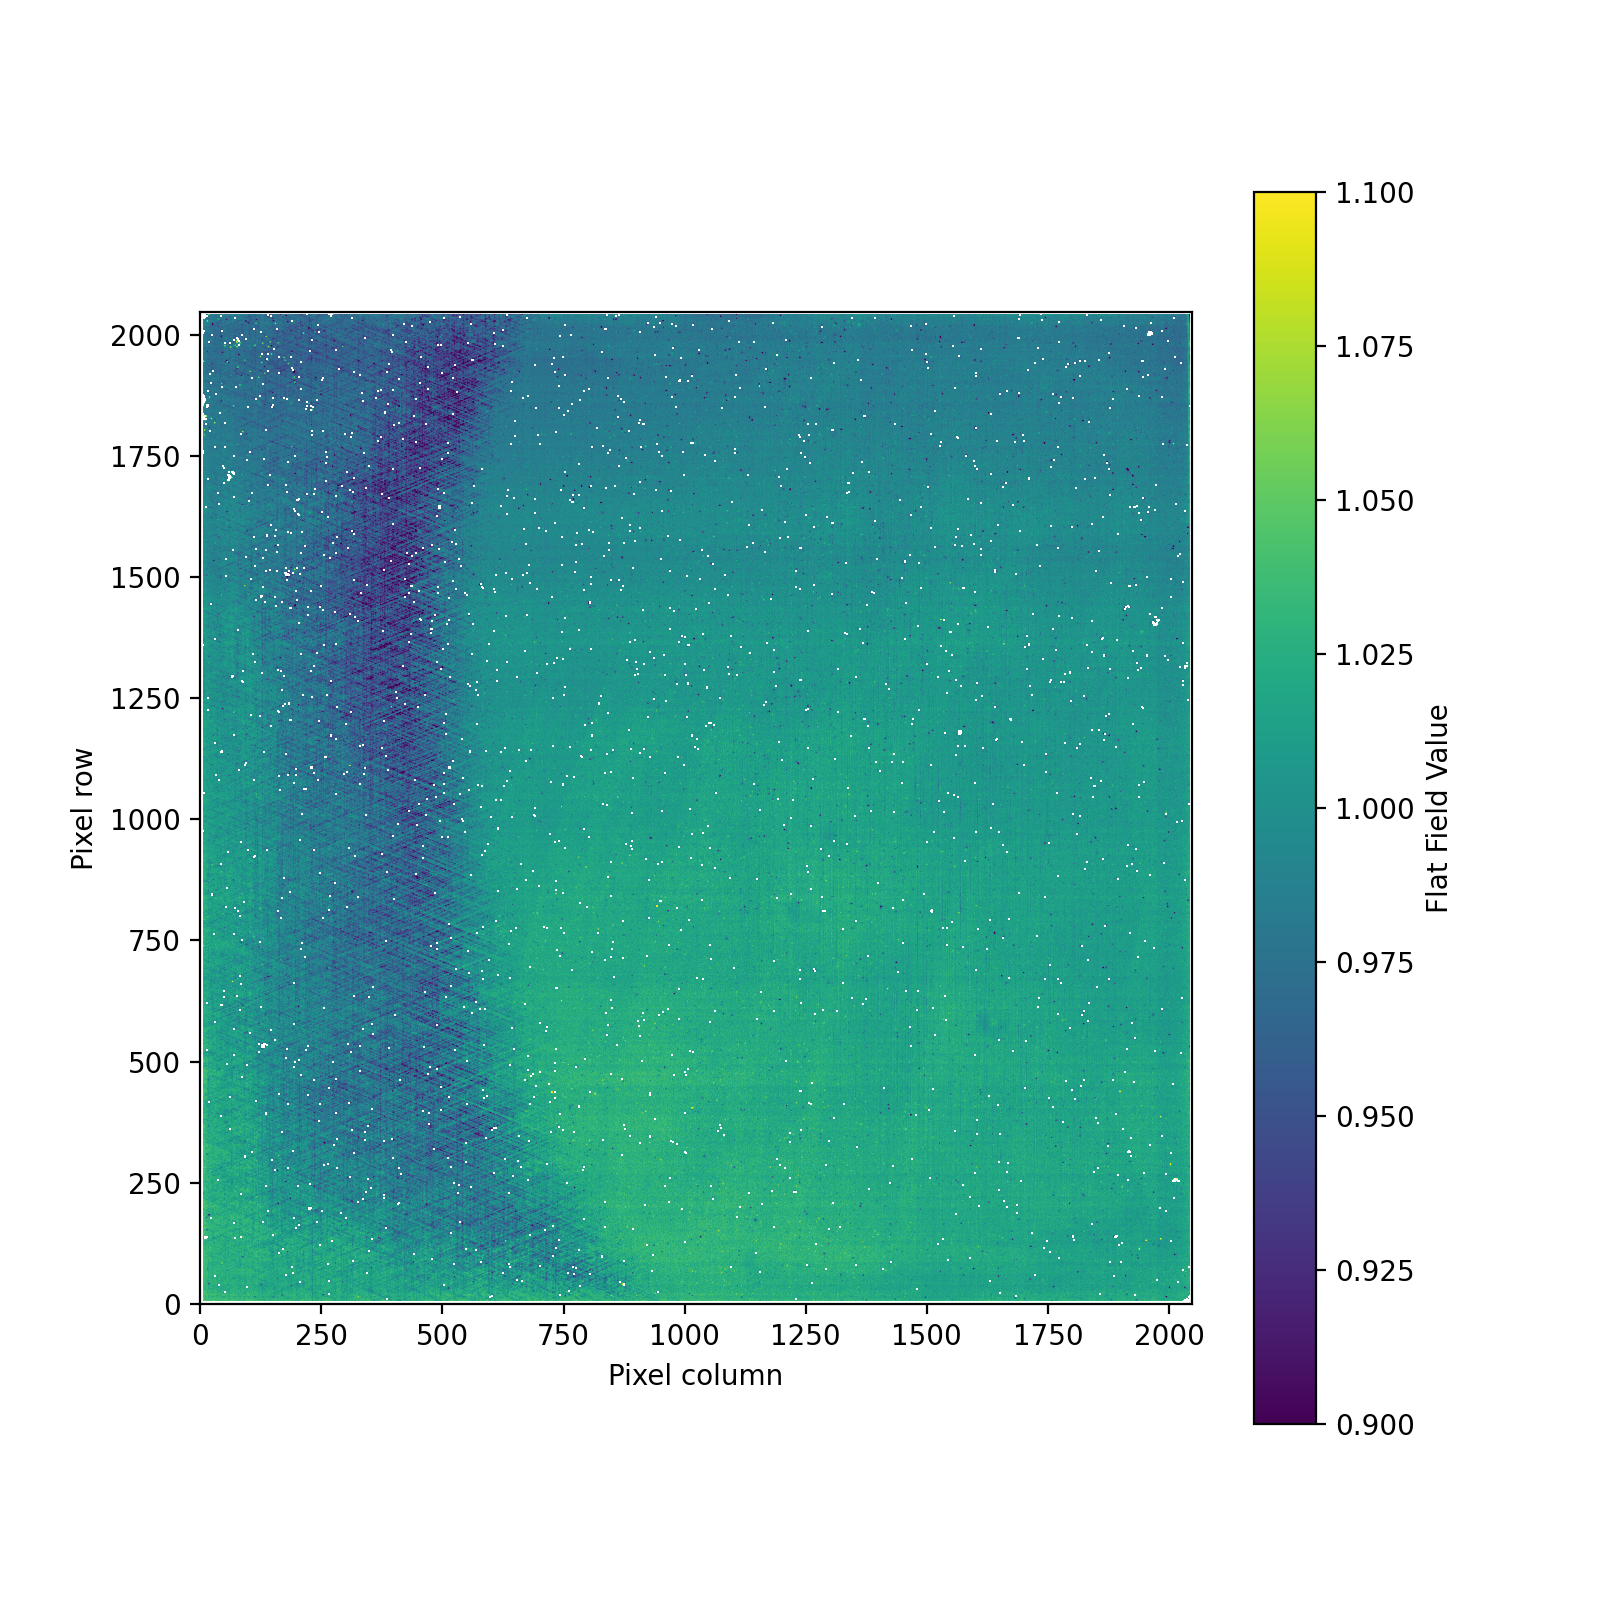

In [122]:
show_image(flat_ratio, 0.9, 1.1, scale='linear', units='Flat Field Value')

 <a id='photom'> </a>
## The `Photometric calibration` step

#### Summary

This step applies flux (photometric) calibration to the data, converting it from units of ADU/sec to surface brightness. A conversion factor is retrieved from the `PHOTOM` reference file, and the pixels values in the science observation are multiplied by this factor. The factor is also saved in the header of the observation in the `PHOTMJSR` keyword. The map of relative pixel areas is appended to the observation in a new file extension called `AREA`. The average pixel area in units of steradians and square arcseconds is also saved in the science extension header, in the `PIXAR_SR` and `PIXAR_A2` keywords.


#### Documentation

[Full description](https://jwst-pipeline.readthedocs.io/en/stable/jwst/photom/main.html) of the step.

#### Arguments

There are no optional arguments for this step

#### Reference files used

This step uses the [`PHOTOM` and `AREA`](https://jwst-pipeline.readthedocs.io/en/stable/jwst/photom/reference_files.html) reference files. The `PHOTOM` reference file contains a table of conversion factors that depend on filter. The `AREA` reference file contains a map of the relative pixel areas across the detector.


#### Run the step

In [123]:
for filename in flatfield_output_files:
    # Using the run() method
    photom_step = PhotomStep()
    photom_step.output_dir = output_dir
    photom_step.save_results = True
    photom_step.run(filename)

2021-03-31 17:06:38,280 - stpipe.PhotomStep - INFO - PhotomStep instance created.
2021-03-31 17:06:38,407 - stpipe.PhotomStep - INFO - Step PhotomStep running with args ('/ifs/jwst/wit/nircam/hilbert/simulated_data_sets/JWebbinars/imaging_mode/output/jw98765001001_01101_00001_nrcb5_flatfieldstep.fits',).
2021-03-31 17:06:38,409 - stpipe.PhotomStep - INFO - Step PhotomStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/ifs/jwst/wit/nircam/hilbert/simulated_data_sets/JWebbinars/imaging_mode/output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2021-03-31 17:06:39,030 - stpipe.PhotomStep - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_nircam_photom_0067.fits
2021-03-31 17:06:39,030 - stpipe.PhotomStep - INFO - Using area reference file: /grp/crds/cache/ref

Let's look at the new information that was added to the output file. 

In [125]:
# When the output is saved, the photom step will
# attach a suffix of 'photomstep' to the input filename.
photom_output_files = sorted(glob(os.path.join(output_dir, '*_photomstep.fits')))

In [138]:
hdulist = fits.open(photom_output_files[0])

In [139]:
hdulist.info()

Filename: /ifs/jwst/wit/nircam/hilbert/simulated_data_sets/JWebbinars/imaging_mode/output/jw98765001001_01101_00001_nrcb5_photomstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     258   ()      
  1  SCI           1 ImageHDU        85   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  AREA          1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (2048, 2048)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [17264B]   


And the mean pixel area:

In [140]:
print('Mean pixel area in steradians: {}, and square arcseconds: {}'
      .format(hdulist['SCI'].header['PIXAR_SR'], hdulist['SCI'].header['PIXAR_A2']))

Mean pixel area in steradians: 9.33677043894089e-14, and square arcseconds: 0.003972344883408201


In [141]:
area_map = hdulist['AREA'].data
science_data = hdulist['SCI'].data
hdulist.close()

Note the new `AREA` extension. Let's have a look:

<IPython.core.display.Javascript object>


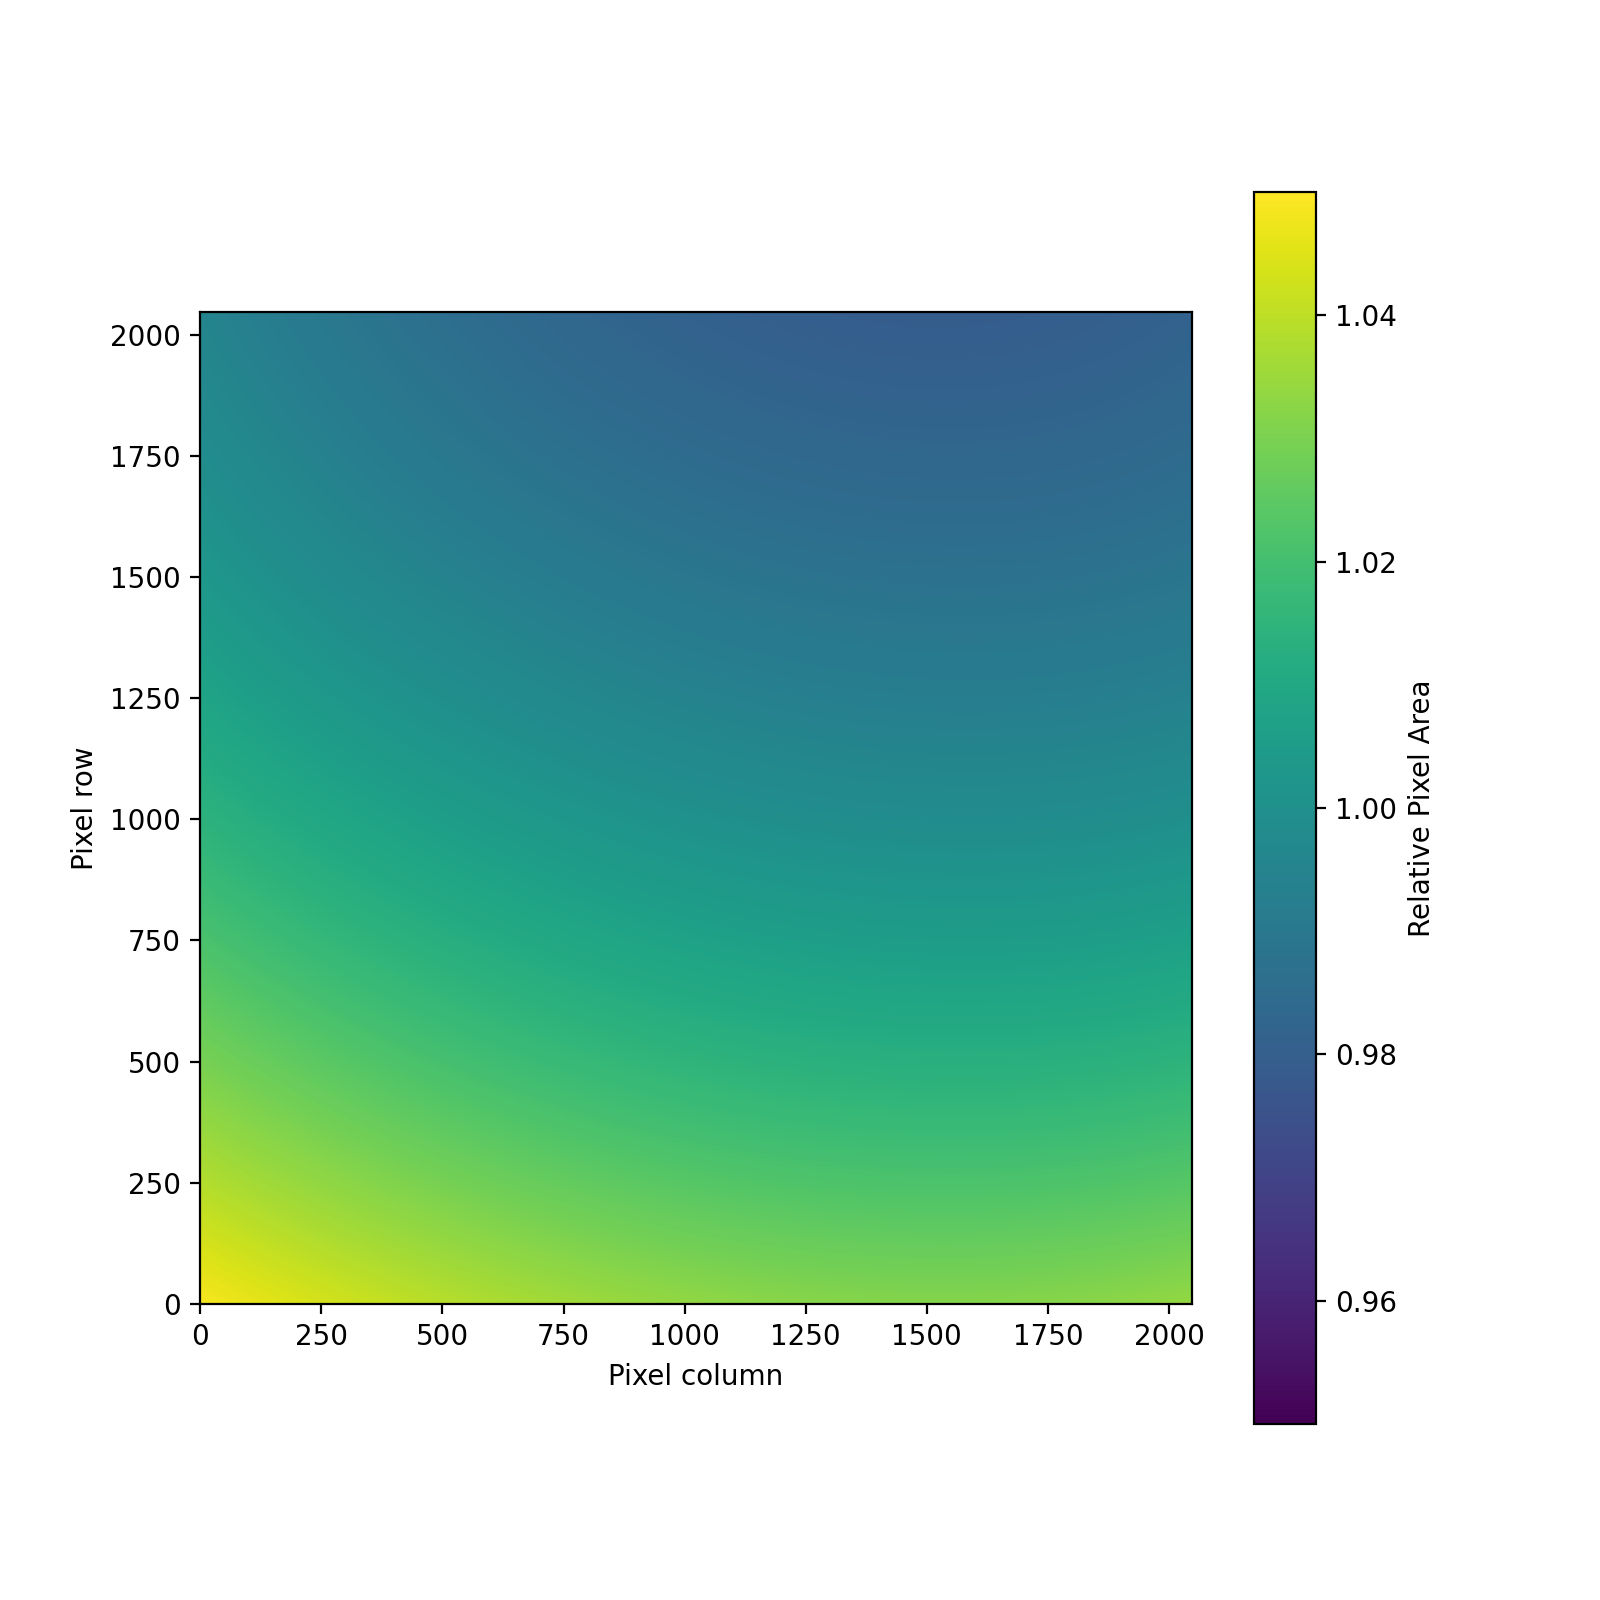

In [142]:
show_image(area_map, 0.95, 1.05, scale='linear', units='Relative Pixel Area')

<IPython.core.display.Javascript object>


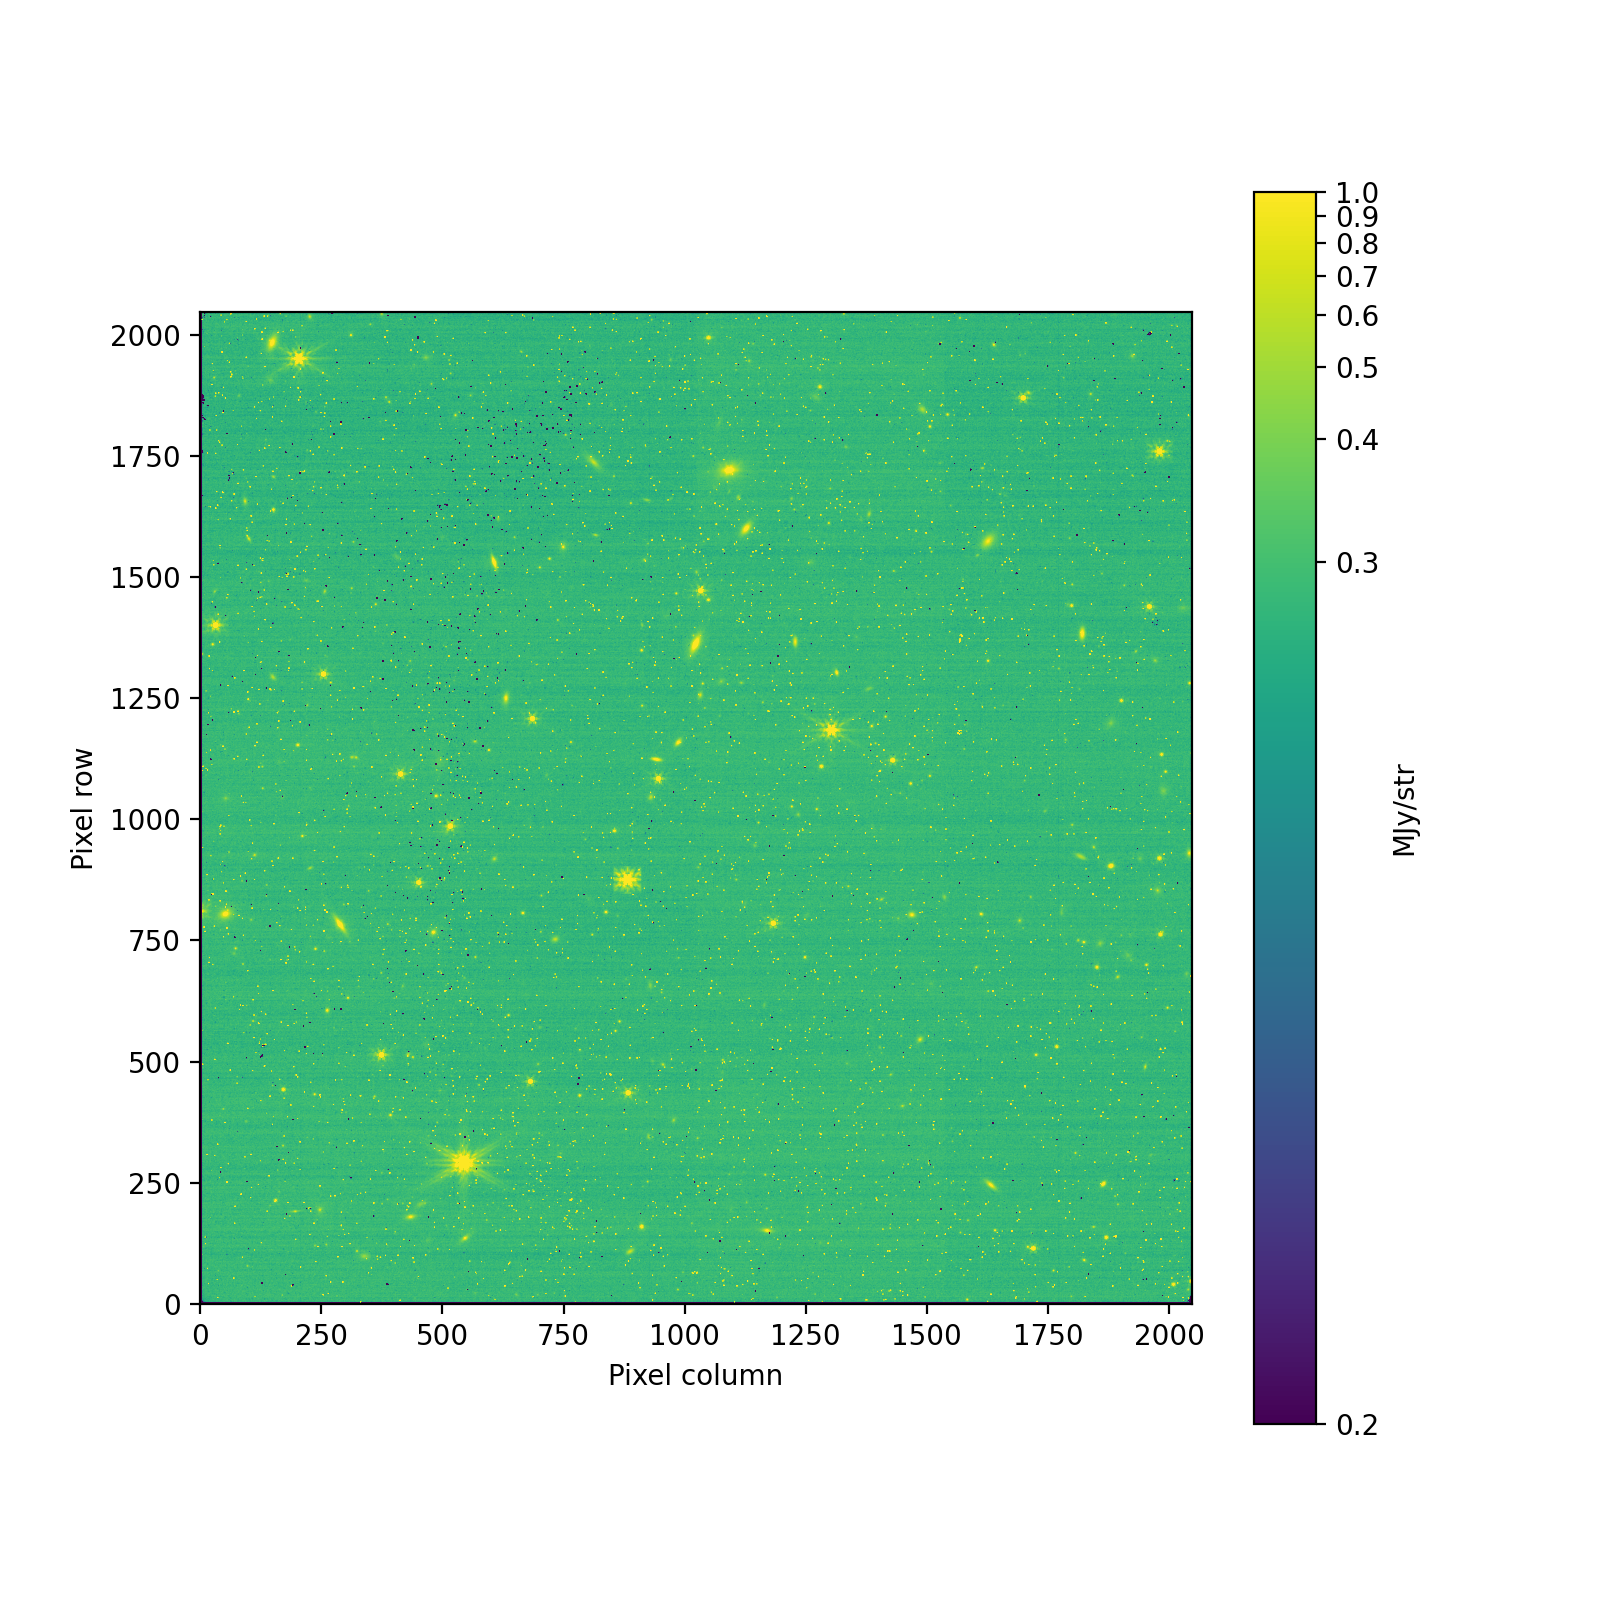

In [144]:
show_image(science_data, 0.2, 1.0)

[Top of Notebook](#top)

This is the end of the Stage 2 pipeline for imaging. The outputs from this, along with a level 3 association file, can now be used as input to the Stage 3 pipeline, where they will be combined into a single mosaic image. This will be shown in the third notebook for this module.